# Implementation of GAN for MNIST digit generation for Sony CSL internship

This is a simple implementation of a GAN, cGAN, e-cGAN and VAEGAN in pytorch for MNIST digit generation


## Requirements

We begin by importing the required libraries and the MNIST dataset, while defining the key global hyperparameters


In [57]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from PIL import Image
from IPython.display import display

# Global hyperparameters
batch_size = 64
device = torch.device("mps")

# GAN Loss function
loss = nn.BCELoss()

# Encoder Loss function
loss_enc = nn.L1Loss()
# loss_enc = nn.MSELoss()


# MNIST is grayscale, so 1 channel
img_channel = 1

# label for real and fake images
real_val = 1
fake_val = 0

# Import dataset, normalise and load into dataloader
mnist = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size, shuffle=True, num_workers=2
)

Next we'll just print some examples of the MNIST dataset to see what we're working with

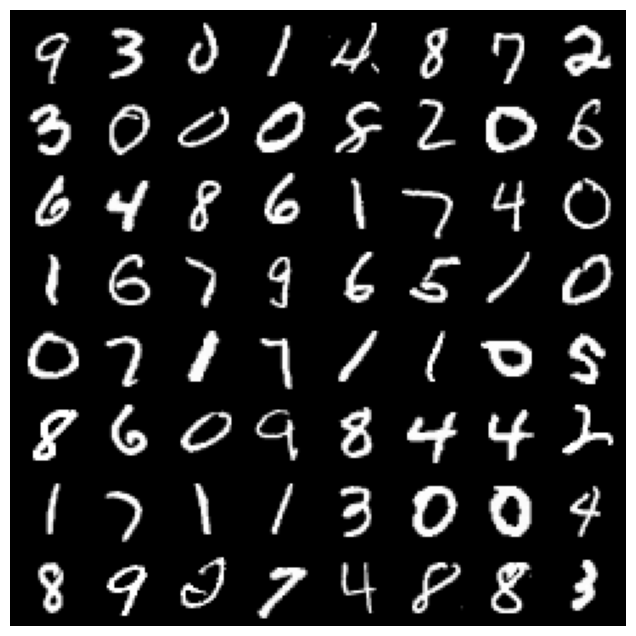

In [58]:
examples = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
grid = np.transpose(
    torchvision.utils.make_grid(examples[0][:64], padding=2, normalize=True),
    (1, 2, 0),
)
plt.imshow(grid)

## Vanilla Generative Adversarial Network (GAN)

<div>
<img src="GAN.png" width="600"/>
</div>

This version of the GAN architecture is quite simple and just simply generates random digits from input noise. The user has no control over the digit that is generated so its not unlikely that the model could suffer from mode collapse.

I've implemented a DCGAN as described in the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) by Radford et al. (2015) which uses transposed convolutions in the generator and convolutions in the discriminator. 

### Model Architecture

In [10]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        
        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)
    

    
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel

        self.model = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)
    

    
# Model Hyperparameters
latent_dim = 100
hidden_dim = 64

# Initialise generator and discriminator
generator = Generator(
    hidden_dim, latent_dim, img_channel).to(device)
print(generator)

discriminator = Discriminator(
    hidden_dim, img_channel).to(device)
print(discriminator)

### Training Functions

In [15]:
def dis_train_step(batch_size, gen, dis, dis_optimiser, loss, real_img):
    # Clear Gradients
    dis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = dis(real_img).squeeze(-1)
    real_loss = loss(validity, real_vals)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    fake = gen(noise)
    validity = dis(fake).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    d_loss = real_loss + fake_loss
    d_loss.backward()
    dis_optimiser.step()
    return d_loss.item()


def gen_train_step(batch_size, gen, dis, gen_optimiser, loss):
    # Clear Gradients
    gen_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    fake = gen(noise)
    validity = dis(fake).squeeze(-1)
    g_loss = loss(validity, real_vals)

    # Update Weights
    g_loss.backward()
    gen_optimiser.step()
    return g_loss.item()

### Training

As you can see the results converge to some degree but the model is not able to generate realistic looking digits. This could improved by increasing the model complexity or implementing techniques such as minibatch discrimination as described in the paper [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498.pdf) by Salimans et al. (2016).


Epoch 1


g_loss: 0.9919525384902954, d_loss: 0.7734707593917847: 100%|██████████| 938/938 [01:05<00:00, 14.39it/s] 

Final Avg: g_loss: 1.2757807337780243, d_loss: 0.8665062153676172


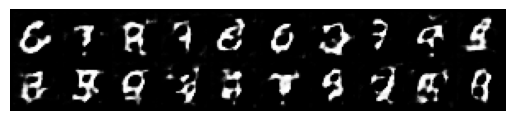

Epoch 2


g_loss: 1.7535407543182373, d_loss: 0.9546424150466919: 100%|██████████| 938/938 [01:04<00:00, 14.62it/s]

Final Avg: g_loss: 1.468031873136187, d_loss: 0.7931456135661363


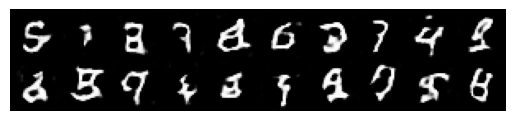

Epoch 3


g_loss: 1.5868033170700073, d_loss: 0.794050931930542: 100%|██████████| 938/938 [01:04<00:00, 14.50it/s] 

Final Avg: g_loss: 1.4827268434994256, d_loss: 0.8404676656860278


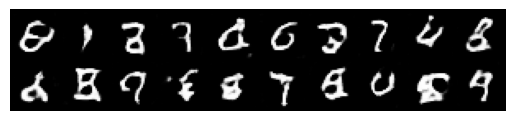

Epoch 4


g_loss: 1.5929930210113525, d_loss: 0.9360746145248413: 100%|██████████| 938/938 [01:06<00:00, 14.19it/s]

Final Avg: g_loss: 1.4690877984581725, d_loss: 0.8800989630252822


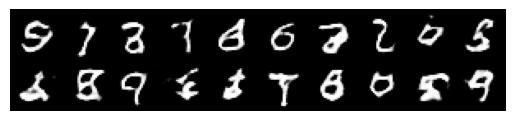

Epoch 5


g_loss: 1.8534646034240723, d_loss: 0.8315288424491882: 100%|██████████| 938/938 [01:06<00:00, 14.18it/s]

Final Avg: g_loss: 1.4571525019242058, d_loss: 0.922904960954113


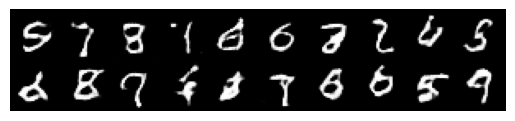

Epoch 6


g_loss: 1.4986686706542969, d_loss: 1.0466488599777222: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]

Final Avg: g_loss: 1.3961164417551524, d_loss: 0.9731480190748854


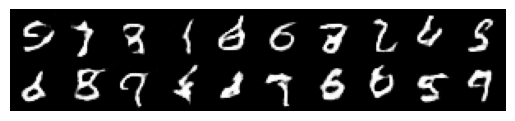

Epoch 7


g_loss: 1.2772281169891357, d_loss: 0.9888595938682556: 100%|██████████| 938/938 [01:03<00:00, 14.67it/s]

Final Avg: g_loss: 1.3601641351226041, d_loss: 1.0222291837750213


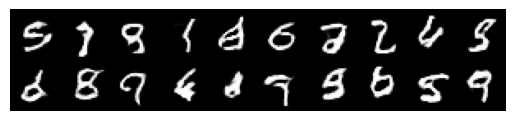

Epoch 8


g_loss: 1.515271782875061, d_loss: 1.2660422325134277: 100%|██████████| 938/938 [01:05<00:00, 14.38it/s] 

Final Avg: g_loss: 1.3076742327035362, d_loss: 1.0547157385583117


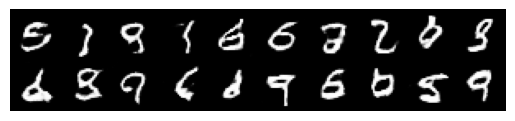

Epoch 9


g_loss: 1.1094533205032349, d_loss: 1.0945930480957031: 100%|██████████| 938/938 [01:06<00:00, 14.00it/s]

Final Avg: g_loss: 1.2722364108064281, d_loss: 1.0884867009323542


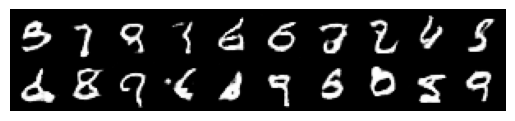

Epoch 10


g_loss: 1.2116117477416992, d_loss: 1.0897687673568726: 100%|██████████| 938/938 [01:05<00:00, 14.39it/s]

Final Avg: g_loss: 1.2352321470088796, d_loss: 1.1141120415252408


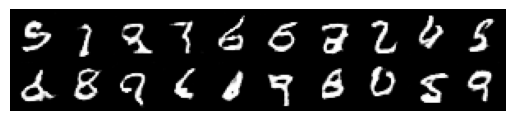

In [56]:
# total number of epochs to train the model
num_epochs = 10

# constant inputs for visualisation
test_noise = torch.randn(20, 100, device=device)

# optimisers
lr = 0.0002
dlr = 0.0001
dis_optimiser = torch.optim.Adam(discriminator.parameters(), lr=dlr, betas=(0.5, 0.999))
gen_optimiser = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    dis_loss_sum = 0
    gen_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, label) in data_iter:
        # Prepare batch
        real_img = images.to(device)
        generator.train()
        batch_size = real_img.shape[0]

        # Train discriminator
        dis_loss = dis_train_step(
            batch_size, generator, discriminator, dis_optimiser, loss, real_img
        )

        # Train generator
        gen_loss = gen_train_step(
            batch_size, generator, discriminator, gen_optimiser, loss
        )

        # Update running loss
        dis_loss_sum += dis_loss
        gen_loss_sum += gen_loss
        if i % 50 == 0:
            data_iter.set_description(
                "g_loss: {}, d_loss: {}".format(gen_loss, dis_loss)
            )
            

    # average loss over epoch
    print(
        "Final Avg: g_loss: {}, d_loss: {}".format(
            gen_loss_sum / len(dataloader), dis_loss_sum / len(dataloader)
        )
    )
    generator.eval()

    # visualise generated images
    sample_images = generator(test_noise).cpu()
    grid = (
        torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True)
        .permute(1, 2, 0)
    )
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

## Conditional GAN (cGAN)

<div>
<img src="cGAN.png" width="600"/>
</div>

The cGAN architecture is similar to the GAN architecture except that the generator and discriminator are conditioned on the class label. This means that the user can specify which digit they want to generate. Not only does this give the user more control, it also ensures the model can generate an example from each of the input classes.

This approach is introduced within the paper [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf) by Mirza et al. (2014). In this paper the authors use a naive approach of one-hot encoding the class label and concatenating it with the input noise vector. Generally the more well used approaches since seem to be to encode the class labels using and embedding layer and injecting them into the generator at various stages during the generation process, allowing the model to still learn a distribution over the class labels. In our case, we will inject our embedding as an extra image channel before the upscaling layers in the generator.

<div>
<img src="Emb.png" width="800"/>
</div>



### Model Architecture

In [22]:
class ConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)
    

    
class ConditionalDiscriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Linear(49, 784),
            nn.Unflatten(1, (1, 28, 28))
        )

        self.downsample = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel + 1, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.label_embedding(y)
        x = torch.cat((x, y), dim=1)
        return self.downsample(x)
    

    
# Model Hyperparameters
latent_dim = 100
hidden_dim = 64
num_classes = 10

# Initialise Conditional Generator and Discriminator
cgenerator = ConditionalGenerator(
    hidden_dim, latent_dim, img_channel, num_classes).to(device)
print(cgenerator)

cdiscriminator = ConditionalDiscriminator(
    hidden_dim, img_channel, num_classes).to(device)
print(cdiscriminator)

### Training Functions

In [25]:
def cdis_train_step(batch_size, cgen, cdis, cdisoptimiser, loss, real_img, labels):
    # Clear Gradients
    cdisoptimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = cdis(real_img, labels).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)  
    fake_labels = torch.randint(0, 10, (batch_size,), device=device) 
    fake = cgen(noise, fake_labels)
    validity = cdis(fake, fake_labels).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    cd_loss = real_loss + fake_loss 
    cd_loss.backward()
    cdisoptimiser.step() 
    return cd_loss.item()



def cgen_train_step(batch_size, cgen, cdis, cgenoptimiser, loss):
    # Clear Gradients
    cgenoptimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    labels = torch.randint(0, 10, (batch_size,), device=device)
    fake = cgen(noise, labels)
    validity = cdis(fake, labels).squeeze(-1)
    cg_loss = loss(validity, real_vals)

    # Update Weights
    cg_loss.backward()
    cgenoptimiser.step()
    return cg_loss.item()

### Training

Epoch 1


g_loss: 3.644941806793213, d_loss: 0.09639329463243484: 100%|██████████| 938/938 [01:11<00:00, 13.21it/s] 

Final: g_loss: 2.980199258401196, d_loss: 0.3842483408042172


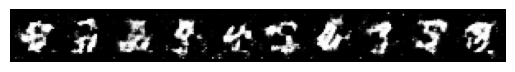

Epoch 2


g_loss: 2.029090166091919, d_loss: 0.4190632700920105: 100%|██████████| 938/938 [01:09<00:00, 13.47it/s]  

Final: g_loss: 2.6499821017545933, d_loss: 0.48787261683470023


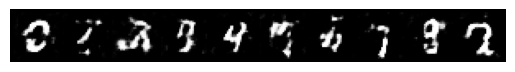

Epoch 3


g_loss: 3.1871933937072754, d_loss: 0.7892640829086304: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s] 

Final: g_loss: 2.4244717879971462, d_loss: 0.5272815681692126


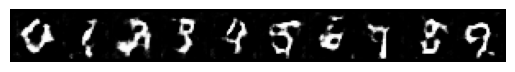

Epoch 4


g_loss: 1.310502529144287, d_loss: 0.925771951675415: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s]   

Final: g_loss: 2.362304696904571, d_loss: 0.6007680226999051


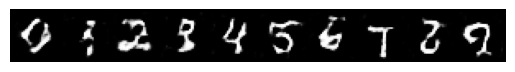

Epoch 5


g_loss: 3.252817153930664, d_loss: 1.324408769607544: 100%|██████████| 938/938 [01:09<00:00, 13.40it/s]  

Final: g_loss: 2.2692658612723036, d_loss: 0.6596837854588719


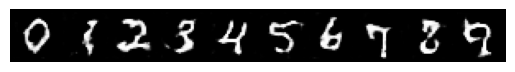

Epoch 6


g_loss: 2.459425449371338, d_loss: 0.7040181159973145: 100%|██████████| 938/938 [01:09<00:00, 13.46it/s]  

Final: g_loss: 2.199485542042169, d_loss: 0.7080512731504847


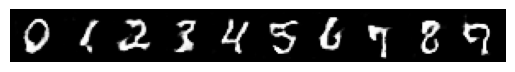

Epoch 7


g_loss: 2.199984073638916, d_loss: 0.5536664128303528: 100%|██████████| 938/938 [01:08<00:00, 13.71it/s]  

Final: g_loss: 2.1873927246342335, d_loss: 0.7217218490805961


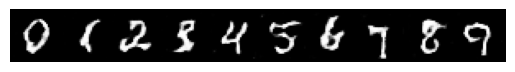

Epoch 8


g_loss: 2.2046005725860596, d_loss: 0.4278721809387207: 100%|██████████| 938/938 [01:08<00:00, 13.64it/s]

Final: g_loss: 2.1478548652327647, d_loss: 0.7413021078559635


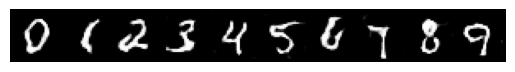

Epoch 9


g_loss: 2.704622745513916, d_loss: 0.8006857633590698: 100%|██████████| 938/938 [01:08<00:00, 13.72it/s] 

Final: g_loss: 2.1381511821040213, d_loss: 0.7616492599757241


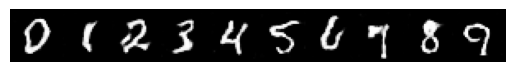

Epoch 10


g_loss: 1.8014895915985107, d_loss: 0.7939102053642273: 100%|██████████| 938/938 [01:08<00:00, 13.73it/s]

Final: g_loss: 2.1116552545444796, d_loss: 0.769005080847852


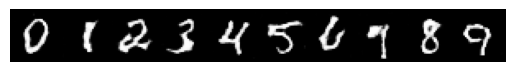

In [27]:
# total number of epochs to train the model
num_epochs = 10

# constant inputs for visualisation
test_noise = torch.randn(10, 100, device=device)
test_labels = torch.LongTensor(np.arange(10)).to(device)

# optimisers
lr = 0.0002
cdis_optimiser = torch.optim.Adam(cdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
cgen_optimiser = torch.optim.Adam(cgenerator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    cdis_loss_sum = 0
    cgen_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, label) in data_iter:
        # Prepare batch
        real_img = images.to(device)
        labels = label.to(device)
        cgenerator.train()
        batch_size = real_img.shape[0]

        # Train discriminator
        cdis_loss = cdis_train_step(
            batch_size, cgenerator, cdiscriminator, cdis_optimiser, loss, real_img, labels,
        )

        # Train generator
        cgen_loss = cgen_train_step(
            batch_size, cgenerator, cdiscriminator, cgen_optimiser, loss
        )

        # Update running loss
        cdis_loss_sum += cdis_loss
        cgen_loss_sum += cgen_loss
        if i % 50 == 0:
            data_iter.set_description(
                "g_loss: {}, d_loss: {}".format(cgen_loss, cdis_loss)
            )

    # average loss over epoch
    print(
        "Final: g_loss: {}, d_loss: {}".format(
            cgen_loss_sum / len(dataloader), cdis_loss_sum / len(dataloader)
        )
    )
    cgenerator.eval()

    # visualise generated images
    sample_images = cgenerator(test_noise, test_labels).cpu()
    grid = (
        torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True)
        .permute(1, 2, 0)
        .numpy()
    )
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

## Encoder Conditional GAN (e-cGAN)

<div>
<img src="ecGAN.png" width="800"/>
</div>

Here I implemented a conditional GAN with an added encoder network attached at the start to generate the latent vector and allowed the user to pretrain the encoder - generator model initially to greatly improve training speed. The arctitecture used here is similar to the paper [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf) by Isola et al. (2016) without the skip connections in their U-Net AE.

### Model Architecture

In [ ]:
class EncoderConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Encoder that produces a 100-dimensional latent vector from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, latent_dim)
        )         
        
        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.encoder(z)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)
    

    
# Model Hyperparameters
latent_dim = 10
hidden_dim = 64
num_classes = 10

# Initialise Encoder Conditional Generator and Discriminator
ecgenerator = EncoderConditionalGenerator(
    hidden_dim, latent_dim, img_channel, num_classes).to(device)
print(ecgenerator)

ecdiscriminator = ConditionalDiscriminator(
    hidden_dim, img_channel, num_classes).to(device)
print(ecdiscriminator)

### Training Functions

In [ ]:
def ecdis_train_step(batch_size, ecgen, cdis, ecdis_optimiser, loss, real_img, labels):
    # Clear Gradients
    ecdis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = cdis(real_img, labels).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    fake = ecgen(real_img, labels)
    validity = cdis(fake, labels).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    ecd_loss = real_loss + fake_loss 
    ecd_loss.backward() 
    ecdis_optimiser.step() 
    return ecd_loss.item() 



def ecgen_train_step(batch_size, aegen, cdis, ecgen_optimiser, loss, loss_enc, real_img, labels):
    # Clear Gradients
    ecgen_optimiser.zero_grad()
    
    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    fake = aegen(real_img, labels) 
    validity = cdis(fake, labels).squeeze(-1)
    g_loss = loss(validity, real_vals)
    e_loss = loss_enc(real_img, fake) 
    
    # Update Weights
    ecg_loss = g_loss + e_loss  
    ecg_loss.backward()  
    ecgen_optimiser.step()  
    return ecg_loss.item()  



def cond_enc_train_step(ecgen, ecgen_optimiser, loss_enc, real_img, labels):
    # Clear Gradients
    ecgen_optimiser.zero_grad() 

    # Train on reconstruction
    fake = ecgen(real_img, labels) 
    e_loss = loss_enc(real_img, fake)
    
    # Update Weights
    e_loss.backward() 
    ecgen_optimiser.step() 
    return e_loss.item() 

### Training

Epoch 1


enc_loss: 0.08242447674274445: 100%|██████████| 938/938 [00:39<00:00, 23.52it/s]

Final Avg: enc_loss: 0.115411717079278


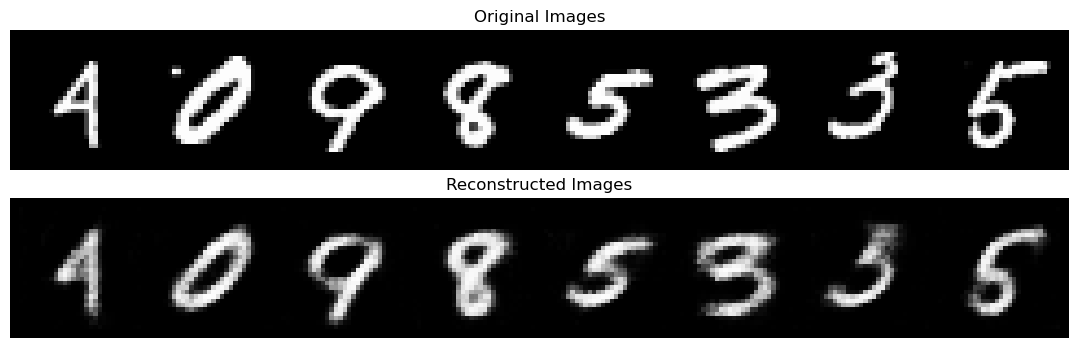

Epoch 2


g_loss: 0.806774377822876, d_loss: 1.42244291305542: 100%|██████████| 938/938 [01:27<00:00, 10.72it/s]   

Final Avg: g_loss: 0.8375120594430325, d_loss: 1.4280123089168117


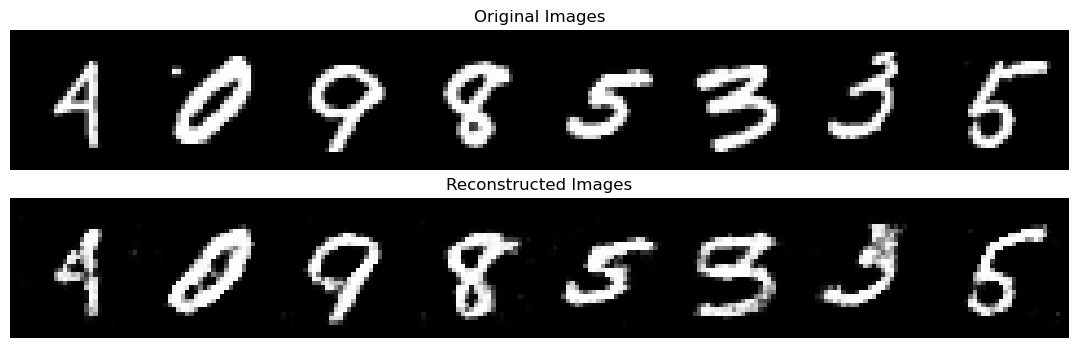

Epoch 3


g_loss: 0.7927603721618652, d_loss: 1.3932687044143677: 100%|██████████| 938/938 [01:27<00:00, 10.77it/s]

Final Avg: g_loss: 0.8222228198417468, d_loss: 1.399347552739735


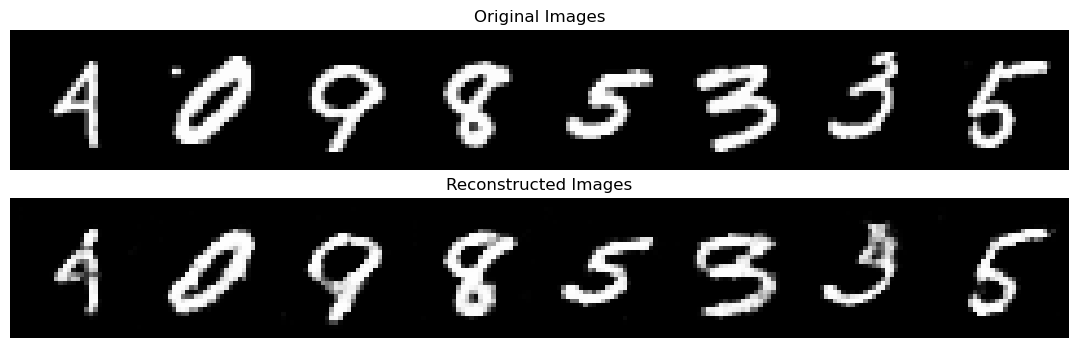

Epoch 4


g_loss: 0.8043383359909058, d_loss: 1.4142003059387207:  37%|███▋      | 348/938 [00:33<00:56, 10.53it/s]


KeyboardInterrupt: 

In [ ]:
# total number of epochs to train the model
num_epochs = 10
# pre-train the encoder only
enc_warmup_epochs = 1

# Constant images for visualisation
test_imgs, test_labels = next(iter(dataloader))
test_imgs = test_imgs[:8].to(device)
test_labels = test_labels[:8].to(device)

# optimisers
lr=0.0002
ecgen_optimiser = torch.optim.Adam(ecgenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(ecdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    # Avg epoch losses
    ecdis_loss_sum = 0 
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, labels) in data_iter:
        # Prepare batch 
        real_img = images.to(device)
        labels = labels.to(device)
        ecgenerator.train()
        batch_size = real_img.shape[0]

        # (opt) Pre-train encoder
        if epoch < enc_warmup_epochs:
            enc_loss = cond_enc_train_step(
                ecgenerator, ecgen_optimiser, loss_enc, real_img, labels
            )

            # Update running loss
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                data_iter.set_description('enc_loss: {}'.format(enc_loss))

        # Train discriminator
        else:
            ecdis_loss = ecdis_train_step(
                batch_size, ecgenerator, ecdiscriminator, ecdis_optimiser, loss, real_img, labels
                )
            
            ecgen_loss = ecgen_train_step(
                batch_size, ecgenerator, ecdiscriminator, ecgen_optimiser, loss, loss_enc, real_img,  labels
                )
            
            # Update running loss
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                data_iter.set_description('g_loss: {}, d_loss: {}'.format(ecgen_loss, ecdis_loss))

    # average loss over epoch
    if epoch < enc_warmup_epochs:
        print(
            'Final Avg: enc_loss: {}'.format(
                enc_loss_sum / len(dataloader)
            )
        )
    else:
        print(
            'Final Avg: g_loss: {}, d_loss: {}'.format(
                ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader)
            )
        )
    
    ecgenerator.eval()

    # Visualise the progress of the model each epoch
    sample_images = ecgenerator(test_imgs, test_labels).cpu()
    fig, axs = plt.subplots(2, figsize=(16, 4))

    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")
    axs[0].set_title("Original Images")

    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    plt.show()

## Variational Auto Encoder GAN (VAEGAN)

<div>
<img src="VAEGAN.png" width="800"/>
</div>

Here we implement the VAEGAN architecture which substitutes the generator in the GAN architecture with a variational autoencoder. This essentially improves the characteristic over-smoothed quality of VAE images by introducing the adversarial loss from the GAN architecture. This is described in the paper [Autoencoding beyond pixels using a learned similarity metric](https://arxiv.org/pdf/1512.09300.pdf) by Larsen et al. (2015). I initially implemented this as a simple Autoencoder GAN but decided to add the gaussian sampling layer to add more variety. 

### Model Architecture

In [36]:
class AutoEncoderGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel

        # Encoder that produces a 2 latent vectors from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, 2 * latent_dim)
        ) 

        # VAE sampling layer samples from the latent distribution
        self.sampling = nn.Sequential(
        )


        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        z = self.encoder(z)
        return self.model(z)
    

    
# Model Hyperparameters
latent_dim = 10
hidden_dim = 64

# Initialise Encoder Conditional Generator and Discriminator
aegenerator = AutoEncoderGenerator(
    hidden_dim, latent_dim, img_channel).to(device)
print(aegenerator)

aediscriminator = Discriminator(
    hidden_dim, img_channel).to(device)
print(aediscriminator)

### Training Functions

In [38]:
def aedis_train_step(batch_size, aegen, dis, aedis_optimiser, loss, real_img):
    # Clear Gradients
    aedis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = dis(real_img).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    fake = aegen(real_img)
    validity = dis(fake).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    dloss = real_loss + fake_loss 
    dloss.backward() 
    aedis_optimiser.step() 
    return dloss.item() 



def aegen_train_step(batch_size, aegen, dis, aegen_optimiser, loss, loss_enc, real_img):
    # Clear Gradients
    aegen_optimiser.zero_grad()
    
    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    fake = aegen(real_img) 
    validity = dis(fake).squeeze(-1)
    g_loss = loss(validity, real_vals)
    e_loss = loss_enc(real_img, fake) 
    
    # Update Weights
    aeg_loss = g_loss + e_loss  
    aeg_loss.backward()  
    aegen_optimiser.step()  
    return aeg_loss.item()  



def enc_train_step(ecgen, aegen_optimiser, loss_enc, real_img):
    # Clear Gradients
    aegen_optimiser.zero_grad() 

    # Train on reconstruction
    fake = ecgen(real_img) 
    e_loss = loss_enc(real_img, fake)
    
    # Update Weights
    e_loss.backward() 
    aegen_optimiser.step() 
    return e_loss.item() 

### Training

Epoch 1


enc_loss: 0.08296006917953491: 100%|██████████| 938/938 [00:32<00:00, 29.10it/s]

Final Avg: enc_loss: 0.11332358064046547


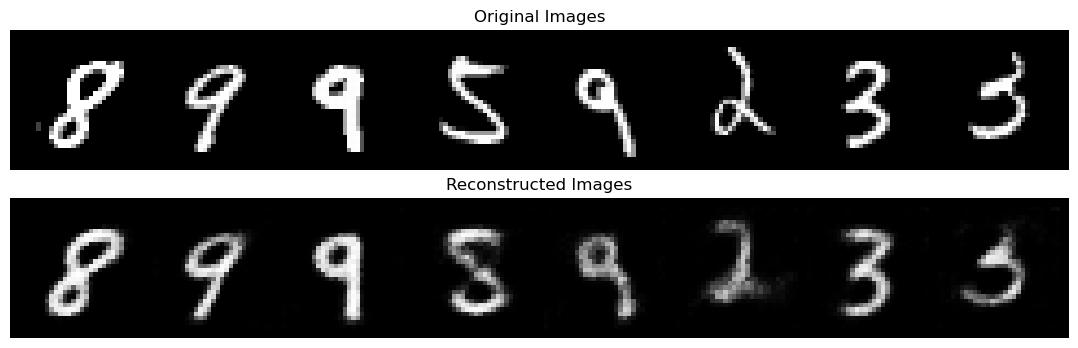

Epoch 2


g_loss: 0.9196474552154541, d_loss: 1.3367395401000977: 100%|██████████| 938/938 [01:09<00:00, 13.40it/s]

Final Avg: g_loss: 0.922628352192165, d_loss: 1.3935080569690224


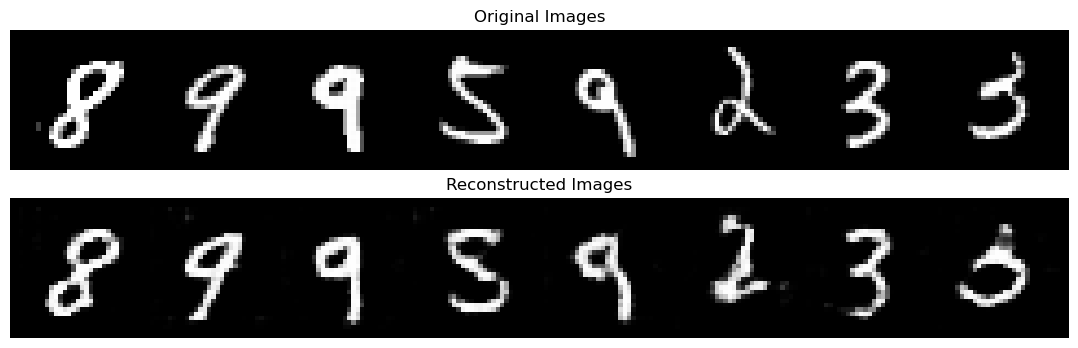

Epoch 3


g_loss: 0.8374475240707397, d_loss: 1.3298428058624268:   8%|▊         | 75/938 [00:06<01:12, 11.90it/s]


KeyboardInterrupt: 

In [44]:
# total number of epochs to train the model
num_epochs = 10
# pre-train the encoder only
enc_warmup_epochs = 1

# Constant images for visualisation
test_imgs = next(iter(dataloader))[0][:8].to(device)

# optimisers
lr=0.0002
ecgen_optimiser = torch.optim.Adam(aegenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(aediscriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    # Avg epoch losses
    ecdis_loss_sum = 0 
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, _) in data_iter:
        # Prepare batch 
        real_img = images.to(device)
        aegenerator.train()
        batch_size = real_img.shape[0]

        # (opt) Pre-train encoder
        if epoch < enc_warmup_epochs:
            enc_loss = enc_train_step(
                aegenerator, ecgen_optimiser, loss_enc, real_img
            )

            # Update running loss
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                data_iter.set_description('enc_loss: {}'.format(enc_loss))

        # Train discriminator
        else:
            ecdis_loss = aedis_train_step(
                batch_size, aegenerator, aediscriminator, ecdis_optimiser, loss, real_img
                )
            
            ecgen_loss = aegen_train_step(
                batch_size, aegenerator, aediscriminator, ecgen_optimiser, loss, loss_enc, real_img
                )
            
            # Update running loss
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                data_iter.set_description('g_loss: {}, d_loss: {}'.format(ecgen_loss, ecdis_loss))

    # average loss over epoch
    if epoch < enc_warmup_epochs:
        print('Final Avg: enc_loss: {}'.format(enc_loss_sum / len(dataloader)))
    else:
        print('Final Avg: g_loss: {}, d_loss: {}'.format(ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader))) # Print the loss values
    
    # Visualise the progress of the model each epoch
    aegenerator.eval()
    sample_images = aegenerator(test_imgs).cpu()
    fig, axs = plt.subplots(2, figsize=(16, 4))

    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")
    axs[0].set_title("Original Images")

    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    plt.show()